Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en
Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Funciones

Definimos las siguientes funciones para el trabajo práctico:

1. **Mejor_escala:**
Esta función busca la mejor escala del template en la imagen utilizando el coeficiente de correlación normalizado como métrica de evaluación (TM_CCOEFF_NORMED). Se considera que la mejor correlación es la que tiene el valor más alto de este coeficiente, identificando así el "mejor logo encontrado" en este contexto. La función devuelve entonces:
  - el template reescalado según el mejor valor
  - la escala óptima
  - el valor del coeficiente de correlación normalizado correspondiente a esa escala.

2. **Detección múltiple:**
Esta función calcula el coeficiente de correlación normalizado para toda la imagen. Basándose en los valores máximos que superen un umbral (threshold) predefinido, la función devuelve la imagen con las regiones detectadas marcadas. Esto permite identificar múltiples instancias del logo dentro de la misma imagen.
Usamos la función de Non-Maximum Supression para eliminar detecciones redundantes en los boxes marcados. La función devuelve la imagen recibida con los boxes marcados

3. **Generar_rangos**
Genera rangos de escalado de template según parámetro de tamaño imagen

In [2]:
def mejor_escala(img, template, scale_factors_x, scale_factors_y, sd=1.6):

  #Filtro suavizado
  img = cv.GaussianBlur(img, (7,5), sd)
  #Detección de bordes
  edges_img_multi = cv.Canny(img, 300,400)

  mejor_escala = -1
  best_template = None
  best_loc = None

  for scale_x in scale_factors_x:
    for scale_y in scale_factors_y:
      #Resize de template
      temp_res = cv.resize(template, None, fx=scale_x, fy=scale_y, interpolation=cv.INTER_CUBIC)

      #Aplicamos algoritmo de Canny para detección de bordes
      edges_template_multi = cv.Canny(temp_res, 1, 150)

      # Si la escala no sobrepasa a las dimensiones de la imagen
      if temp_res.shape [0] < img.shape[0] and temp_res.shape[1] < img.shape[1]:
        comp = cv.matchTemplate(edges_img_multi, edges_template_multi, cv.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(comp)

        #Gaurdo los máximos
        if max_val > mejor_escala:
          mejor_escala = max_val
          best_template = temp_res
          best_loc = max_loc

  return best_template, mejor_escala, best_loc

In [3]:
def deteccion_multiple(img, template, threshold, nms_threshold=0.3):
  img_salida = img.copy()

  # Aplicamos algoritmo de Canny para detección de bordes de imagen y template
  edges_img_multi = cv.Canny(img, 300, 400)
  edges_template_multi = cv.Canny(template, 1, 150)

  w, h = template.shape[::-1]

  # Evaluamos template en la imagen y obtenemos los puntos donde el valor del coef normalizdo es mayor al treshold
  res = cv.matchTemplate(edges_img_multi, edges_template_multi, cv.TM_CCOEFF_NORMED)
  loc = np.where(res >= threshold)

  boxes = []
  confidences = []

  # Marcamos los puntos encontrados
  for pt in zip(*loc[::-1]):
      boxes.append([pt[0], pt[1], w, h])
      confidences.append(float(res[pt[1], pt[0]]))

  boxes = np.array(boxes)
  confidences = np.array(confidences)

  # Usamos cv.dnn.NMSBoxes para aplicar NMS y eliminar boxes redunadantes en la detección
  indices = cv.dnn.NMSBoxes(boxes.tolist(), confidences.tolist(), threshold, nms_threshold)

  if len(indices) > 0:
      for i in indices.flatten():
          box = boxes[i]
          pt1 = (box[0], box[1])
          pt2 = (box[0] + box[2], box[1] + box[3])
          cv.rectangle(img_salida, pt1, pt2, (0, 255, 0), 2)
          text = f'Confianza: {confidences[i]:.2f}'
          cv.putText(img_salida, text, (pt1[0], pt1[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

  return img_salida

In [4]:
def generar_rangos(size):
  if size == 'small':
    scale_factors_x = scale_factors_y = [round(i, 2) for i in np.arange(0.2, 0.5, 0.1)]
  elif size == 'medium':
    scale_factors_x = scale_factors_y = [round(i, 2) for i in np.arange(0.5, 2.5, 0.1)]
  else:
    scale_factors_x = scale_factors_y = [round(i, 2) for i in np.arange(3,4, 0.1)]

  return scale_factors_x, scale_factors_y

# Punto 1
Obtener una detección del logo en cada imagen sin falsos positivos.

Para este punto usamos la función definida **Mejor_escala** para otener la mejor escala del template junto con el punto de mayor coeficiente de correlación (normalizado). El inconveniente que encontramos en aplicar el algoritmo para todas las imágenes con la búsqueda de escalamiento del template, es que la correcta detección de un verdadero positivo es dependiente de los factores de escala que va evaluar la función, si el rango es muy amplio sucede que con templates pqueños la correlación es alta con otras features de la imagen o el fondo y el punto marcado no es el correcto. Se evaluaron distintas estrategias de preprocesado de imagen, template, píramides en las imagenes, rangos de detección de bordes; entre otros; pero en todos los casos la limitante se mantuvo.

Para solventar esto, decidimos correr el algoritmo con 3 factores de escala (pequeño, mediano y grande) y previamente sabiendo cómo es el tamaño del logo respecto a la imagen, es que deidimos cuál rango de escala usar en cada caso.

## Logos Pequeños


In [5]:
scale_factors_x, scale_factors_y = generar_rangos(size='small')
print(scale_factors_x)

[0.2, 0.3, 0.4]


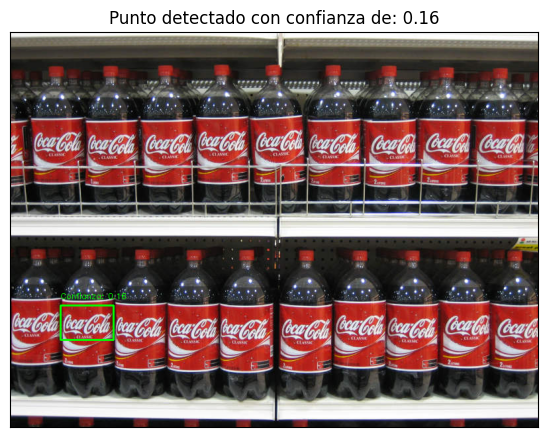

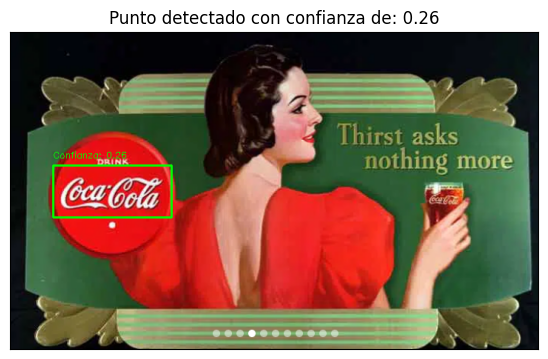

In [6]:
#Rutas de imagenes
imagenes = ['/content/coca_multi.png','/content/coca_retro_2.png']

template = cv.imread('/content/pattern.png')
template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)


for i in imagenes:
  img_multi = cv.imread(i)
  img_m_rgb= cv.cvtColor(img_multi, cv.COLOR_BGR2RGB)
  img_m_gray= cv.cvtColor(img_multi, cv.COLOR_BGR2GRAY)

  mejor_template_m, mejor_escala_m, max_loc = mejor_escala(img_multi, template, scale_factors_x, scale_factors_y)

  img_salida = img_m_rgb.copy()
  w, h = mejor_template_m.shape[::-1]
  # Marcamos el lugar donde lo haya encontrado
  #----------------------------------------
  bottom_right = (max_loc[0] + w, max_loc[1] + h)
  cv.rectangle(img_salida,max_loc, bottom_right,(0,255,0), 2)

  # Añadimos el nivel de confianza
  text = f'Confianza: {mejor_escala_m:.2f}'
  cv.putText(img_salida, text, (max_loc[0], max_loc[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

  # Graficamos el procesamiento y la salida
  #----------------------------------------
  plt.figure(figsize=(15, 15))

  # Imagen original con recuadros
  plt.subplot(122),plt.imshow(img_salida)
  plt.title(f'Punto detectado con confianza de: {mejor_escala_m:.2f}'), plt.xticks([]), plt.yticks([])

  plt.show()

## Logos Medianos

In [7]:
scale_factors_x, scale_factors_y = generar_rangos(size='medium')
print(scale_factors_x)

[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]


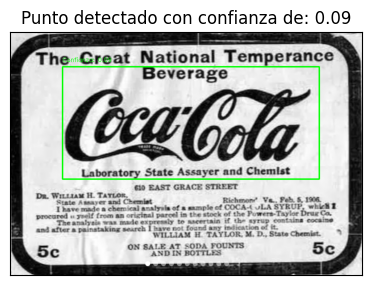

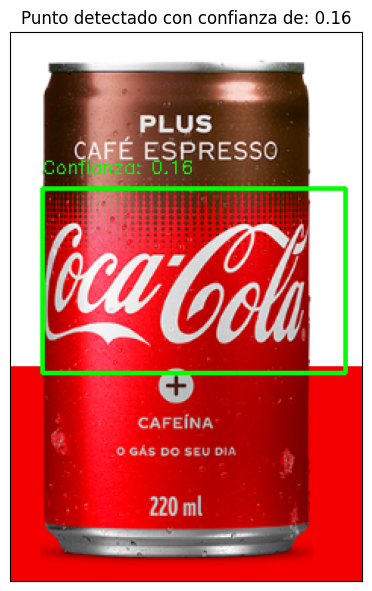

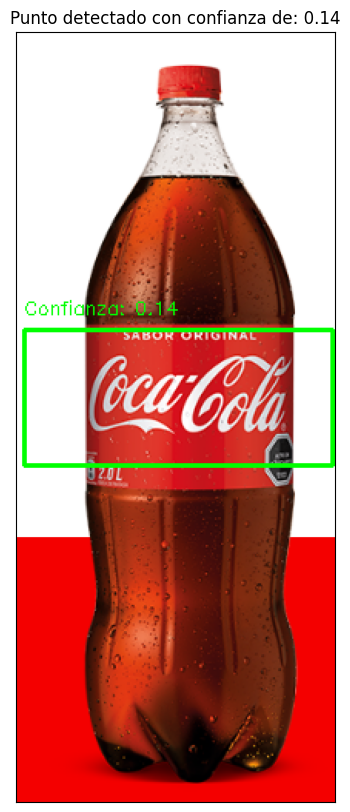

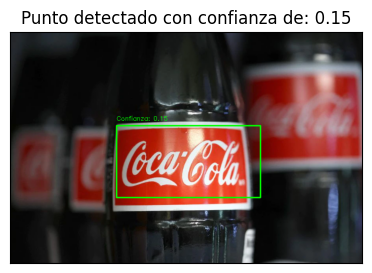

In [8]:
#Rutas de imagenes
imagenes = ['/content/coca_retro_1.png','/content/coca_logo_2.png','/content/coca_logo_1.png','/content/logo_1.png'] #

template = cv.imread('/content/pattern.png')
template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)


for i in imagenes:
  img_multi = cv.imread(i)
  img_m_rgb= cv.cvtColor(img_multi, cv.COLOR_BGR2RGB)
  img_m_gray= cv.cvtColor(img_multi, cv.COLOR_BGR2GRAY)

  mejor_template_m, mejor_escala_m, max_loc = mejor_escala(img_multi, template, scale_factors_x, scale_factors_y)

  img_salida = img_m_rgb.copy()
  w, h = mejor_template_m.shape[::-1]
  # Marcamos el lugar donde lo haya encontrado
  #----------------------------------------
  bottom_right = (max_loc[0] + w, max_loc[1] + h)
  cv.rectangle(img_salida,max_loc, bottom_right,(0,255,0), 2)

  # Añadimos el nivel de confianza
  text = f'Confianza: {mejor_escala_m:.2f}'
  cv.putText(img_salida, text, (max_loc[0], max_loc[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

  # Graficamos el procesamiento y la salida
  #----------------------------------------
  plt.figure(figsize=(10, 10))

  # Imagen original con recuadros
  plt.subplot(122),plt.imshow(img_salida)
  plt.title(f'Punto detectado con confianza de: {mejor_escala_m:.2f}'), plt.xticks([]), plt.yticks([])

  plt.show()


## Logos Grandes

In [9]:
scale_factors_x, scale_factors_y = generar_rangos(size='big')
print(scale_factors_x)

[3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9]


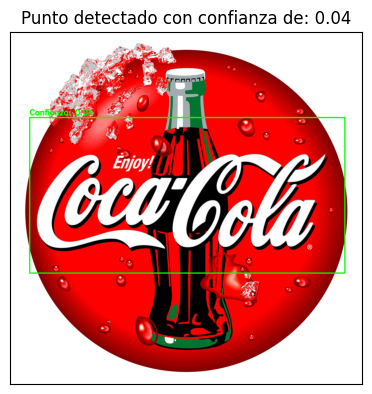

In [10]:
#Rutas de imagenes
imagenes = ['/content/COCA-COLA-LOGO.jpg'] #

template = cv.imread('/content/pattern.png')
template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)


for i in imagenes:
  img_multi = cv.imread(i)
  img_m_rgb= cv.cvtColor(img_multi, cv.COLOR_BGR2RGB)
  img_m_gray= cv.cvtColor(img_multi, cv.COLOR_BGR2GRAY)

  mejor_template_m, mejor_escala_m, max_loc = mejor_escala(img_m_rgb, template, scale_factors_x, scale_factors_y)

  img_salida = img_m_rgb.copy()
  w, h = mejor_template_m.shape[::-1]
  # Marcamos el lugar donde lo haya encontrado
  #----------------------------------------
  bottom_right = (max_loc[0] + w, max_loc[1] + h)
  cv.rectangle(img_salida,max_loc, bottom_right,(0,255,0), 4)

  # Añadimos el nivel de confianza
  text = f'Confianza: {mejor_escala_m:.2f}'
  cv.putText(img_salida, text, (max_loc[0], max_loc[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4)

  # Graficamos el procesamiento y la salida
  #----------------------------------------
  plt.figure(figsize=(10, 10))

  # Imagen original con recuadros
  plt.subplot(122),plt.imshow(img_salida)
  plt.title(f'Punto detectado con confianza de: {mejor_escala_m:.2f}'), plt.xticks([]), plt.yticks([])

  plt.show()

# Punto 2

Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1.

En este caso, se usaron ambas funciones, de forma tal que primerose escaló y se obtuvo el mejor template con el mejor valor de correlación, que se usó para llamar a la función de detección múltiple. A dicha función se le pasó como parámetro el template escalado y se usó como medida del treshold el 75% del valor máximo de correlación (encontrado de la función inicial de escalado de template)

Como resultado vemos que marccca bien todas las etiquetas, menos la última (esquina dercha, abajo) que vemos que está cortada y no tiene el logo completo

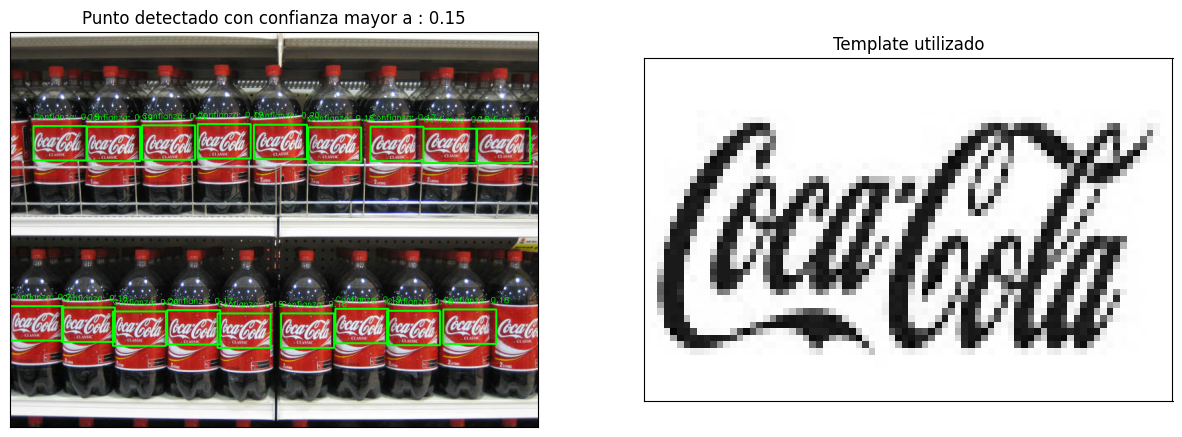

In [11]:
# Carga de imagen y template
img_multi = cv.imread('/content/coca_multi.png')
img_multi_rgb= cv.cvtColor(img_multi, cv.COLOR_BGR2RGB)
img_multi_gray= cv.cvtColor(img_multi, cv.COLOR_BGR2GRAY)

template = cv.imread('/content/pattern.png')
template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

# Factores de escala
scale_factors_x = [round(i, 2) for i in np.arange(0.2, 1, 0.10)]
scale_factors_y = [round(i, 2) for i in np.arange(0.2, 1, 0.10)]

# Búsqueda de la mejor escala para el template, y obtengo el valor del coef. de correlación normalizado para esa detección (única)
mejor_template_m, mejor_escala_m, max_loc = mejor_escala(img_multi_rgb, template, scale_factors_x, scale_factors_y, sd=0)

# Llamada al algoritmo de detección múltiple usando la escala encontrada y usandocomo treshold el valor correspondiente al 70% del mejor valor
if (mejor_template_m is not None):
    treshold_m = mejor_escala_m*0.75
    img_det = deteccion_multiple(img_multi_rgb,mejor_template_m, treshold_m) #uso como treshold el 75% del mejor valor

    #Graficosfig
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.imshow(img_det)
    plt.title(f'Punto detectado con confianza mayor a : {treshold_m:.2f}'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2)
    plt.imshow(mejor_template_m,cmap='gray')
    plt.title('Template utilizado'), plt.xticks([]), plt.yticks([])
    plt.show()


# Punto 3

Usamos la misma función que el punto 2, pero con el criterio de escalas del punto 1

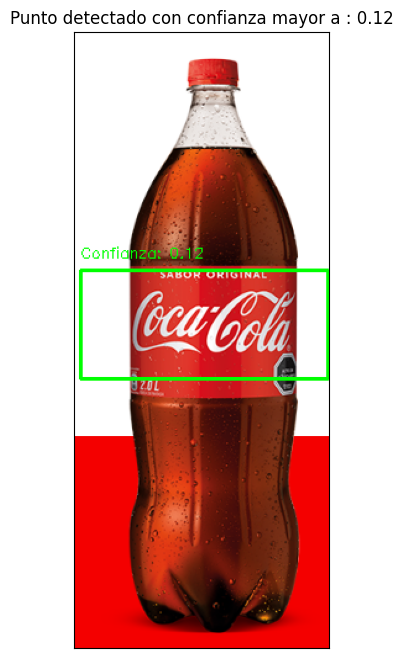

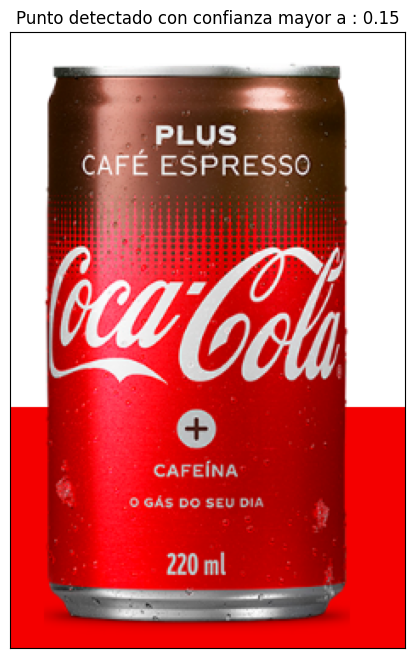

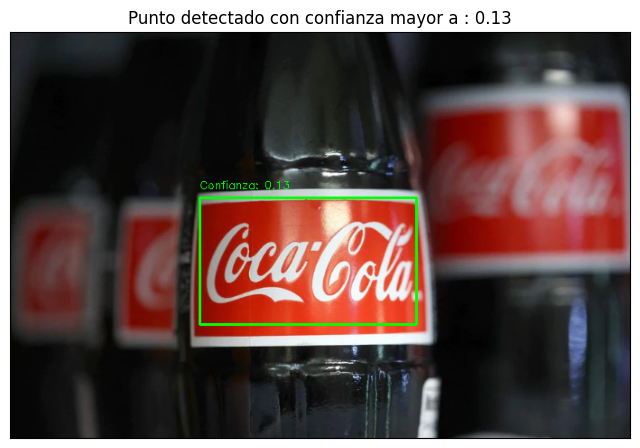

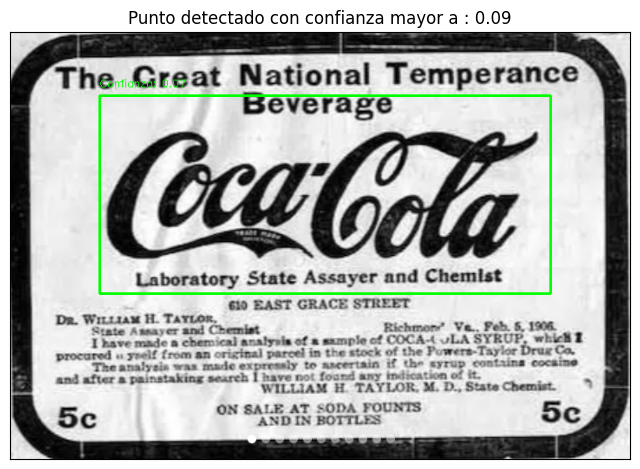

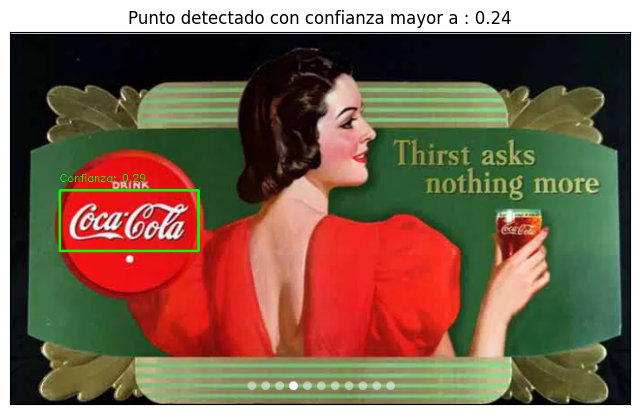

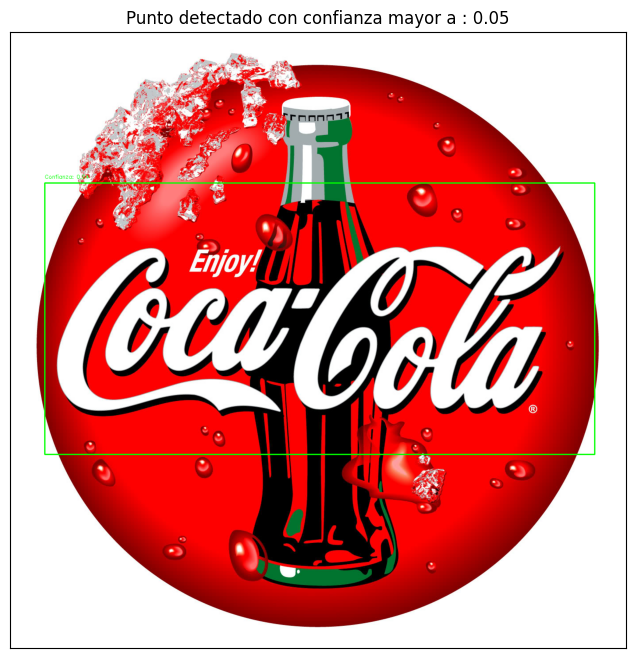

In [12]:
#Rutas de imagenes
imagenes = ['/content/coca_logo_1.png','/content/coca_logo_2.png','/content/logo_1.png','/content/coca_retro_1.png','/content/coca_retro_2.png','/content/COCA-COLA-LOGO.jpg'] #
tamaño_scale = ['medium','medium','medium','medium','small','big']

for i, imagen in enumerate(imagenes):

  mejor_template_m = None

  #Carga imagen
  img_multi = cv.imread(imagen)
  img_multi_rgb= cv.cvtColor(img_multi, cv.COLOR_BGR2RGB)
  img_multi_gray= cv.cvtColor(img_multi, cv.COLOR_BGR2GRAY)

  #Template
  template = cv.imread('/content/pattern.png')
  template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

  # Factores de escala
  scale_factors_x, scale_factors_y = generar_rangos(size=tamaño_scale[i])

  # Búsqueda de la mejor escala para el template, y obtengo el valor del coef. de correlación normalizado para esa detección (única)
  mejor_template_m, mejor_escala_m, max_loc = mejor_escala(img_multi_rgb, template, scale_factors_x, scale_factors_y, sd = 2)

  # Llamada al algoritmo de detección múltiple usando la escala encontrada y usandocomo treshold el valor correspondiente al 70% del mejor valor
  if (mejor_template_m is not None):
    img_det = deteccion_multiple(img_multi_rgb,mejor_template_m, mejor_escala_m*0.75) #uso como treshold el 75% del mejor valor

    #Graficosfig
    plt.figure(figsize=(8, 8))
    plt.imshow(img_det)
    plt.title(f'Punto detectado con confianza mayor a : {mejor_escala_m:.2f}'), plt.xticks([]), plt.yticks([])
    plt.show()